# 迴歸(Regression)與時間序列(Time Series) 比較

## 載入相關套件

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

## 載入資料集

In [2]:
df = pd.read_csv('../nlp_data/airline-passengers.csv')
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


## 資料轉換

In [3]:
# 設定為日期的資料型態
df['Date'] = pd.to_datetime(df['Month'])

# 設定日期為 DataFrame 的索引值
df = df.set_index('Date')

# 依照資料內容設定日期的頻率
df.index = pd.DatetimeIndex(df.index.values,
                               freq=df.index.inferred_freq)
# 將原有欄位刪除
df.drop('Month', axis=1, inplace=True)

## 繪圖

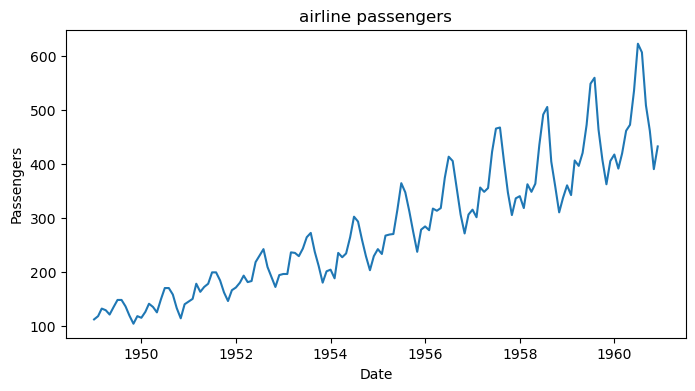

In [4]:
plt.figure(figsize=(8, 4))
sns.lineplot(x=df.index, y='Passengers', data=df)
plt.xlabel('Date')
plt.title('airline passengers');

## 迴歸(Regression)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lr = LinearRegression()
X = np.arange(df.shape[0]).reshape(-1, 1)
y = df['Passengers']
lr.fit(X, y)
pred = lr.predict(X)
print('MSE =', mean_squared_error(y, pred))

MSE = 2091.7994339346533


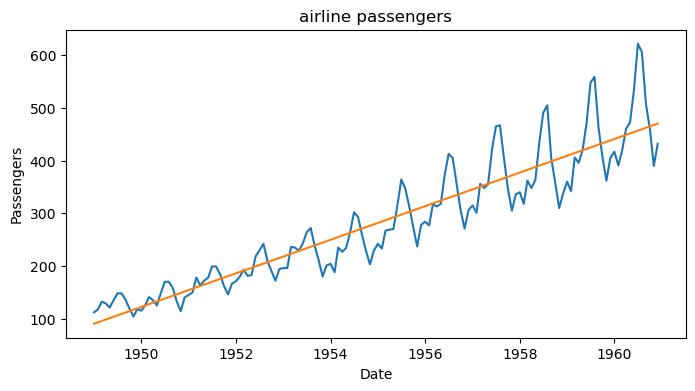

In [6]:
# 實際樣本點
plt.figure(figsize=(8, 4))
sns.lineplot(x=df.index, y='Passengers', data=df)
plt.title('airline passengers')
plt.xlabel('Date')

# 預測迴歸線
plt.plot(df.index, pred);

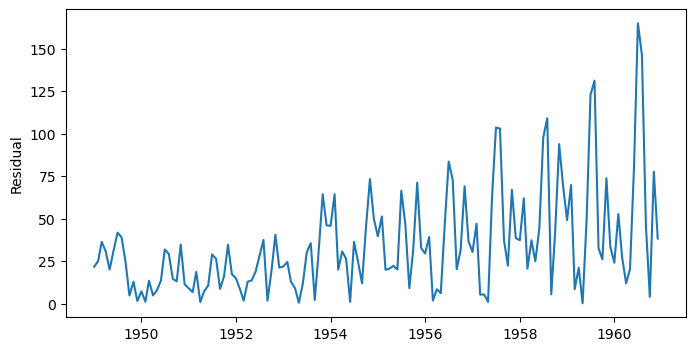

In [7]:
# 殘差線圖
plt.figure(figsize=(8, 4))
plt.plot(df.index, np.abs(df['Passengers'] - pred))
plt.ylabel('Residual');

## 定態測試(Augmented Dickey–Fuller Test for Stationarity)

In [8]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Passengers'])
print(F'ADF統計量: {result[0]}\np value: {result[1]}' + \
      f'\n滯後期數(Lags): {result[2]}\n資料筆數: {result[3]}')

ADF統計量: 0.8153688792060352
p value: 0.9918802434376408
滯後期數(Lags): 13
資料筆數: 130


## 結論：p > 0.05 ==> 殘差非穩態

## ACF/PACF

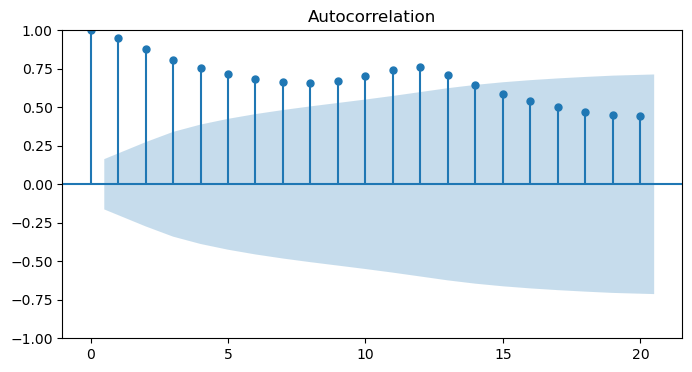

In [9]:
# ACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plot_acf(df['Passengers'], lags=20)
fig.set_size_inches(8, 4)

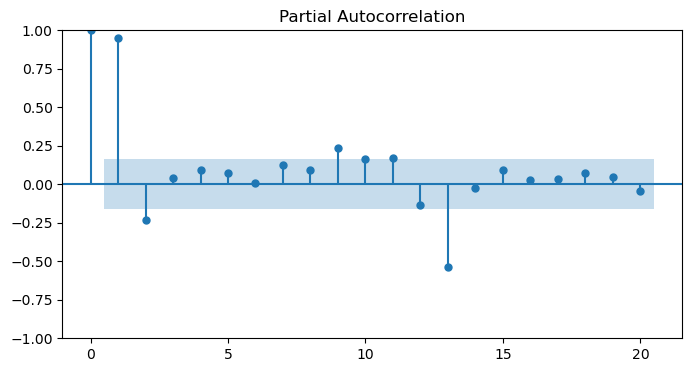

In [10]:
# PACF
fig = plot_pacf(df['Passengers'], lags=20, method='ywm')
fig.set_size_inches(8, 4)

## 時間序列(Time Series)

In [11]:
from statsmodels.tsa.arima.model import ARIMA

# 建立時間序列資料
series = df.copy()

# AR(1) 模型訓練 
ar = ARIMA(df, order=(1,0,0))
model = ar.fit()

# 顯示模型訓練報告
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -711.090
Date:                Wed, 15 Jan 2025   AIC                           1428.181
Time:                        11:07:19   BIC                           1437.090
Sample:                    01-01-1949   HQIC                          1431.801
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.2943     66.403      4.221      0.000     150.146     410.442
ar.L1          0.9645      0.019     51.535      0.000       0.928       1.001
sigma2      1118.5409    122.133      9.158      0.0

In [12]:
model.params

const      280.294340
ar.L1        0.964549
sigma2    1118.540873
dtype: float64

In [13]:
df['Passengers'].mean()

280.2986111111111

## 繪圖：比較實際值與預測值

In [14]:
model.fittedvalues

1949-01-01    280.294340
1949-02-01    117.966280
1949-03-01    123.753571
1949-04-01    137.257251
1949-05-01    134.363605
                 ...    
1960-08-01    609.886036
1960-09-01    594.453259
1960-10-01    499.927502
1960-11-01    454.593721
1960-12-01    386.110774
Freq: MS, Length: 144, dtype: float64

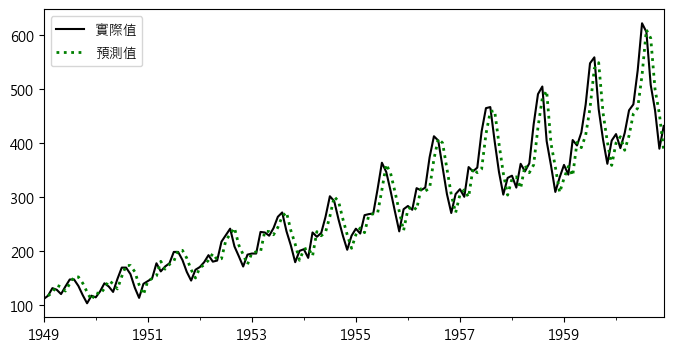

In [15]:
# 修正中文亂碼 
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

series['Passengers'].plot(figsize=(8, 4), color='black', linestyle='-', label='實際值')
model.fittedvalues[1:].plot(figsize=(8, 4), color='green', linestyle=':', lw=2, label='預測值')
plt.legend();

In [16]:
print(f'AR MSE = {(np.sum(model.resid**2) / len(model.resid)):.2f}')

AR MSE = 1301.63


## 使用迴歸驗證

In [17]:
lr2 = LinearRegression() 

# 複製資料
series2 = series.copy()

# 將前一期 y 當作 x
series2['Passengers_1'] = series2['Passengers'].shift(-1)
series2.dropna(inplace=True)
X = series2['Passengers'].values.reshape(series2.shape[0], -1)

# 模型訓練
lr2.fit(X, series2['Passengers_1'])
lr2.coef_, lr2.intercept_

(array([0.95893198]), 13.705504997522155)

<Axes: >

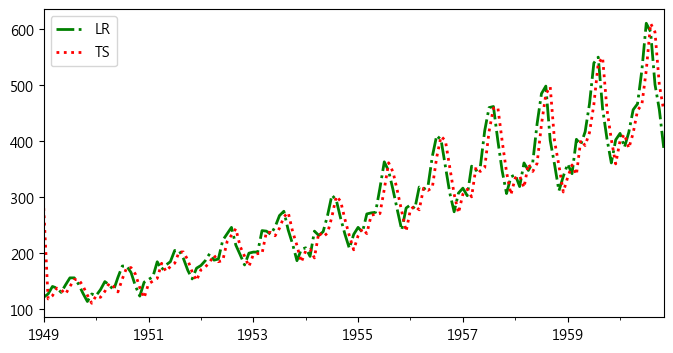

In [18]:
series2['TS'] = model.fittedvalues
series2['LR'] = lr2.coef_ * series['Passengers'] + lr2.intercept_
series2['LR'].plot(color='green', linestyle='-.', lw=2, legend='LR')
series2['TS'].plot(figsize=(8, 4), color='red', linestyle=':', lw=2, legend='TS')

In [19]:
series2[['TS', 'LR']]

,TS,LR
1949-01-01,280.294340,121.105886
1949-02-01,117.966280,126.859478
1949-03-01,123.753571,140.284526
1949-04-01,137.257251,137.407730
1949-05-01,134.363605,129.736274
...,...,...
1960-07-01,525.970313,610.161195
1960-08-01,609.886036,594.818283
1960-09-01,594.453259,500.842949
1960-10-01,499.927502,455.773147


## AR(1) 殘差(residual)繪圖

<Axes: >

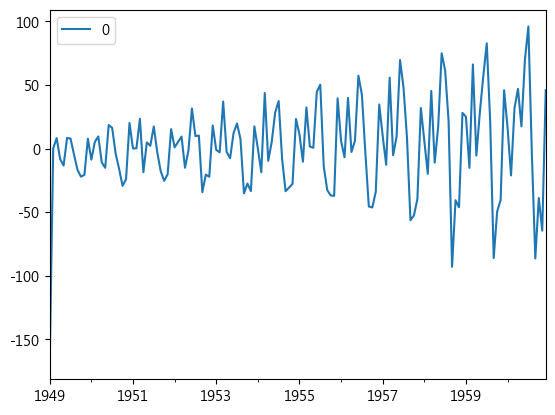

In [20]:
residuals = pd.DataFrame(model.resid)
residuals.plot()

## 資料分割

In [21]:
from sklearn.model_selection import train_test_split

# 資料分割
test_size=12
X_train, X_test = train_test_split(series, test_size=test_size, shuffle=False)

# 查看陣列維度
X_train.shape, X_test.shape

((132, 1), (12, 1))

## 模型訓練、預測與繪圖

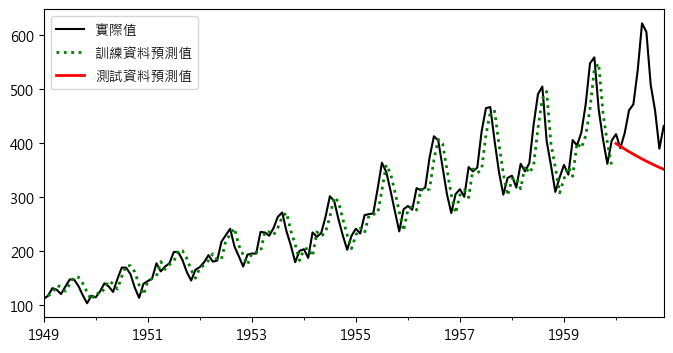

In [22]:
# AR(1) 模型訓練 
ar_1 = ARIMA(X_train[['Passengers']], order=(1,0,0))
model_1 = ar_1.fit()

# 預測 12 個月
pred = model_1.predict(X_train.shape[0] , X_train.shape[0] + test_size - 1)

# 繪圖
series['Passengers'].plot(color='black', linestyle='-', label='實際值')
model_1.fittedvalues[1:].plot(color='green', linestyle=':', lw=2, label='訓練資料預測值')
pred.plot(figsize=(8, 4), color='red', lw=2, label='測試資料預測值')
plt.legend();

# 改用 SARIMAX (Seasonal ARIMA) 演算法

## 一次差分(First-order Differencing)

<Axes: >

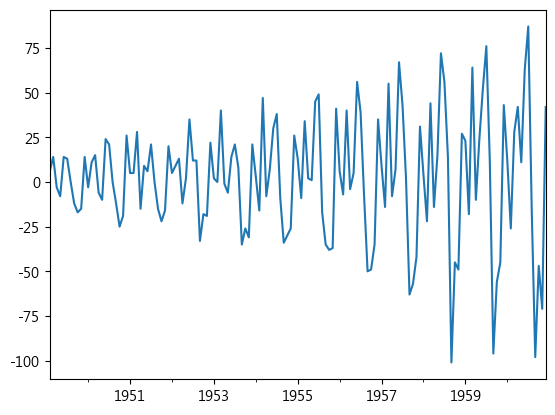

In [23]:
df_diff = df.copy()
df_diff['Passengers_diff'] = df_diff['Passengers'] - df_diff['Passengers'].shift(1)
df_diff.dropna(inplace=True)
df_diff['Passengers_diff'].plot()

## 使用ADF檢定

In [24]:
result = adfuller(df_diff['Passengers_diff'])
print(F'ADF統計量: {result[0]}\np value: {result[1]}' + \
      f'\n滯後期數(Lags): {result[2]}\n資料筆數: {result[3]}')

ADF統計量: -2.8292668241699945
p value: 0.05421329028382621
滯後期數(Lags): 12
資料筆數: 130


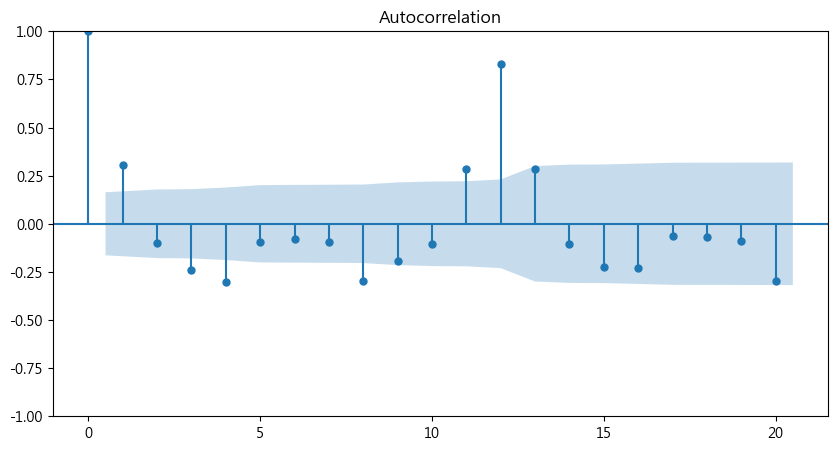

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plot_acf(df_diff['Passengers_diff'], lags=20)
fig.set_size_inches(10, 5)

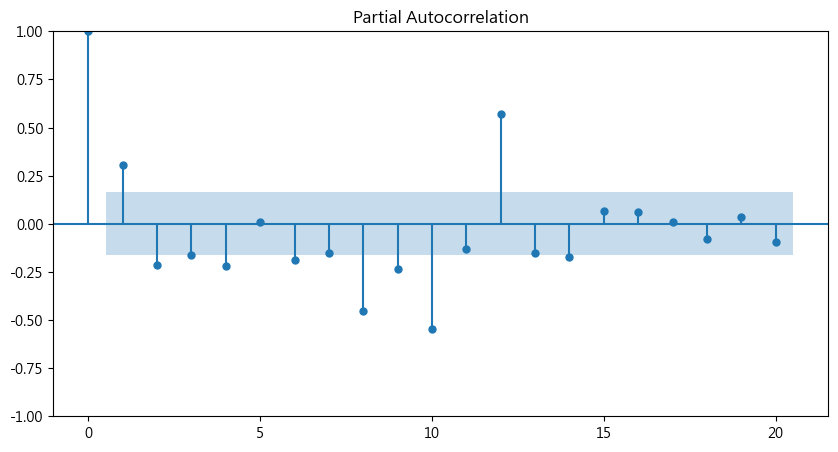

In [26]:
fig = plot_pacf(df_diff['Passengers_diff'], lags=20, method='ywm')
fig.set_size_inches(10, 5)

## 二次差分(Second-order Differencing)

<Axes: >

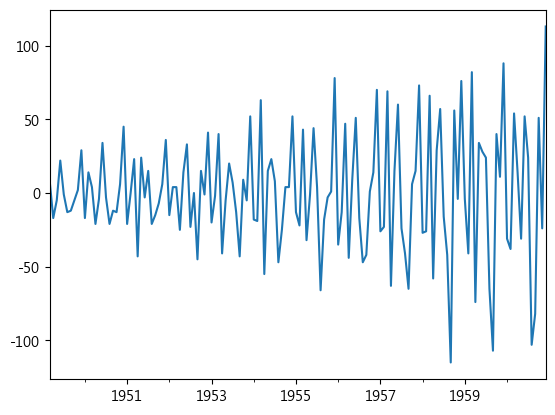

In [27]:
df_diff['Passengers_diff_2'] = df_diff['Passengers_diff'] - df_diff['Passengers_diff'].shift(1) 
df_diff.dropna(inplace=True)

df_diff['Passengers_diff_2'].plot()

## 使用ADF檢定

In [28]:
result = adfuller(df_diff['Passengers_diff_2'])
print(F'ADF統計量: {result[0]}\np value: {result[1]}' + \
      f'\n滯後期數(Lags): {result[2]}\n資料筆數: {result[3]}')

ADF統計量: -16.38423154246852
p value: 2.732891850014085e-29
滯後期數(Lags): 11
資料筆數: 130


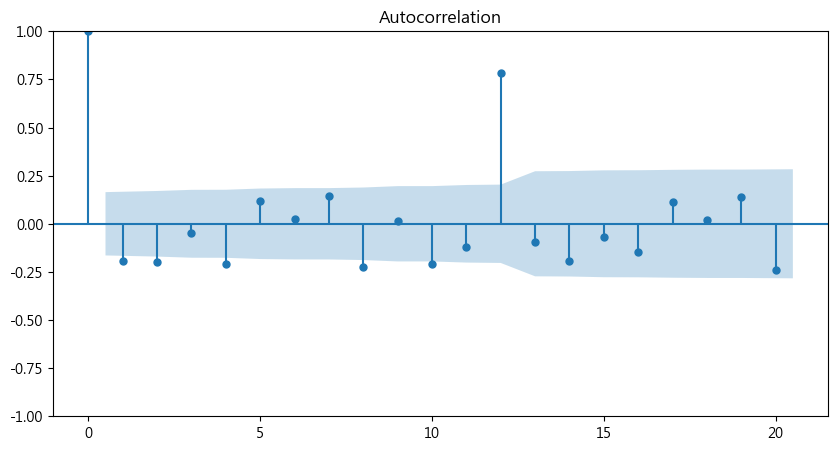

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plot_acf(df_diff['Passengers_diff_2'], lags=20)
fig.set_size_inches(10, 5)

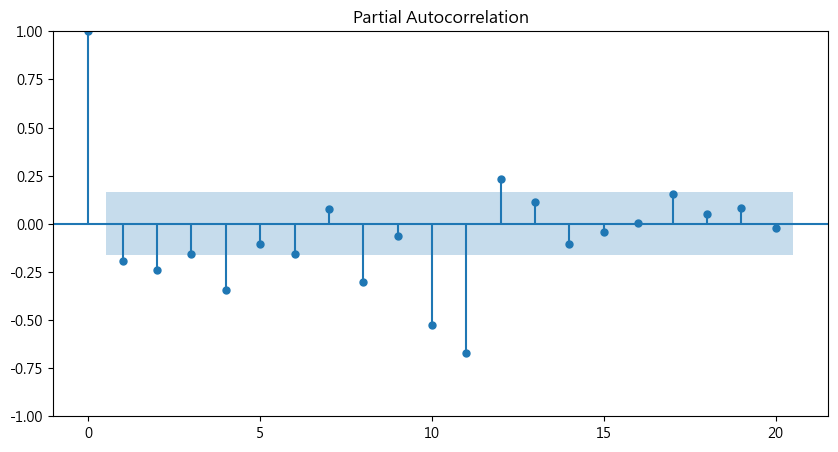

In [30]:
fig = plot_pacf(df_diff['Passengers_diff_2'], lags=20, method='ywm')
fig.set_size_inches(10, 5)

## SARIMAX

In [31]:
# 資料分割
X_train, X_test = train_test_split(df_diff, test_size=12, shuffle=False)

# SARIMAX
import statsmodels.api as sm
ar_diff=sm.tsa.statespace.SARIMAX(X_train[['Passengers']],order=(1, 2, 1),seasonal_order=(1,2,1,12))
model_diff=ar_diff.fit()

# 預測 12 個月
pred = model_diff.predict(X_train.shape[0] , X_train.shape[0] + 12 - 1, dynamic= True)
pred

1960-01-01    421.642899
1960-02-01    400.105329
1960-03-01    464.771656
1960-04-01    453.274174
1960-05-01    479.176527
1960-06-01    542.547627
1960-07-01    620.971969
1960-08-01    634.769375
1960-09-01    526.398025
1960-10-01    469.203813
1960-11-01    419.479457
1960-12-01    461.474830
Freq: MS, Name: predicted_mean, dtype: float64

In [32]:
df_diff['pred'] = np.concatenate((model_diff.fittedvalues.values, pred.values))
df_diff['pred']

1949-03-01      0.000000
1949-04-01    230.989626
1949-05-01    126.022654
1949-06-01    112.993419
1949-07-01    148.996769
                 ...    
1960-08-01    634.769375
1960-09-01    526.398025
1960-10-01    469.203813
1960-11-01    419.479457
1960-12-01    461.474830
Freq: MS, Name: pred, Length: 142, dtype: float64

## 繪圖

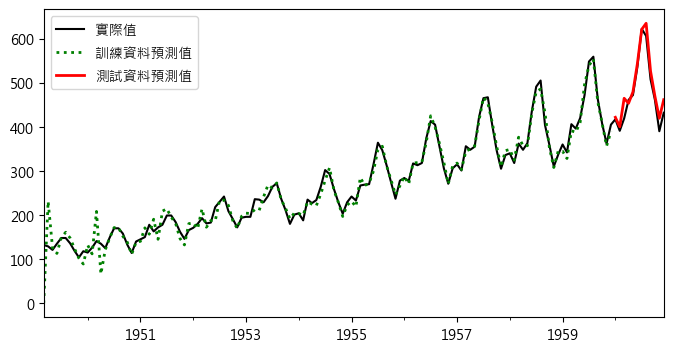

In [33]:
df_diff['Passengers'].plot(color='black', linestyle='-', label='實際值')
model_diff.fittedvalues.plot(color='green', linestyle=':', lw=2, label='訓練資料預測值')
pred.plot(figsize=(8, 4), color='red', lw=2, label='測試資料預測值')
plt.legend();

In [34]:
print(f'SARIMAX MSE = {(np.sum(model_diff.resid**2) / len(model_diff.resid)):.2f}')

SARIMAX MSE = 427.67


## 結論：SARIMAX 準確率比迴歸高
### 時間序列 MSE： 427， 迴歸 MSE： 2091

## 效應分解(Decomposition)

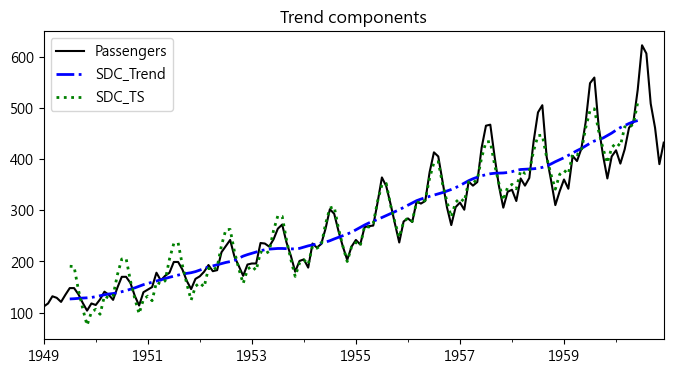

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = pd.read_csv('../nlp_data/airline-passengers.csv')
decomp['Date'] = pd.to_datetime(decomp['Month'])
decomp = decomp.set_index('Date')
decomp.index = pd.DatetimeIndex(df.index.values,
                               freq=decomp.index.inferred_freq)
decomp.drop('Month', axis=1, inplace=True)

s_dc = seasonal_decompose(decomp['Passengers'], model='additive')
decomp['SDC_Seasonal'] = s_dc.seasonal
decomp['SDC_Trend'] = s_dc.trend
decomp['SDC_Error'] = s_dc.resid
decomp['SDC_TS'] = s_dc.trend + s_dc.seasonal


plt.title('Trend components')
decomp['Passengers'].plot(figsize=(8, 4), color='black', linestyle='-', legend='Passengers')
decomp['SDC_Trend'].plot(figsize=(8, 4), color='blue', linestyle='-.', lw=2, legend='SDC_Trend')
decomp['SDC_TS'].plot(figsize=(8, 4), color='green', linestyle=':', lw=2, legend='TS');

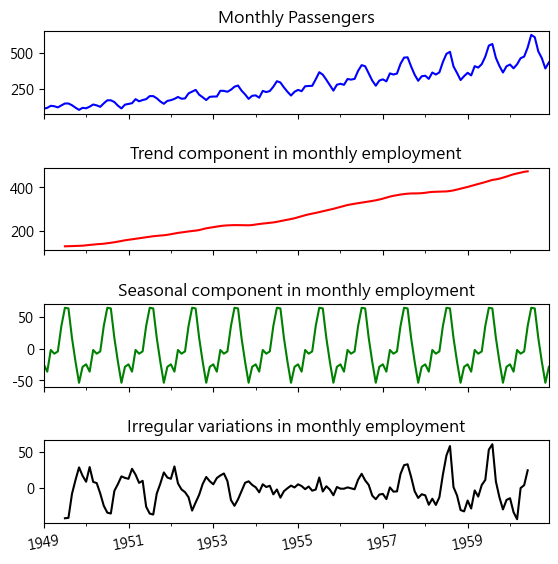

In [36]:
# Plot the original time series, trend, seasonal and random components
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(5.5, 5.5)

decomp['Passengers'].plot(ax=axarr[0], color='b', linestyle='-')
axarr[0].set_title('Monthly Passengers')

pd.Series(data=decomp['SDC_Trend'], index=decomp.index).plot(color='r', linestyle='-', ax=axarr[1])
axarr[1].set_title('Trend component in monthly employment')

pd.Series(data=decomp['SDC_Seasonal'], index=decomp.index).plot(color='g', linestyle='-', ax=axarr[2])
axarr[2].set_title('Seasonal component in monthly employment')

pd.Series(data=decomp['SDC_Error'], index=decomp.index).plot(color='k', linestyle='-', ax=axarr[3])
axarr[3].set_title('Irregular variations in monthly employment')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
fig=plt.xticks(rotation=10)

In [37]:
MSE = (decomp['SDC_Error']**2).sum() / decomp['SDC_Error'].shape[0]
'MSE=', MSE

('MSE=', 340.80467800107556)

## 結論：時間序列預測準確率比迴歸高
### 時間序列 MSE： 340， 迴歸 MSE： 2091